In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sim_data import SimData

In [3]:
from simple_hierarchical_topic_model import (
    SimpleHierarchicalTopicModel,
    StoppingCondition,
    UniformInitializer,
    StatsSaver,
    explore_branching_factors,
)

In [4]:
from init_hierarchy_kmeans import KMeansInitializer

In [5]:
from param_stats import mean_discrete, mean_dirichlet, variance_discrete, norm_variance_dirichlet

In [6]:
np.random.seed(1)

In [7]:
class CustomInitializer(object):
    """
    A custom initializer that can be used to "cheat" and nudge the results closer
    to the desired values, based on stats from the simulation.
    We can use this to verify that variational inference can find the desired value
    if it starts sufficiently close to it.
    """
    def __init__(self, sim, topics_noise = 0.0):
        self.sim = sim
        self.topics_noise = topics_noise

    def init_var_params(self, var, shape):
        sim = self.sim
        if var == "L": return np.ones((sim.num_docs * sim.doc_length, sim.num_leaves))
        if var == "D": return np.ones((sim.num_docs * sim.doc_length, sim.num_depths))
        if var == "DL": return np.broadcast_to(sim.alpha_leaves, (sim.num_docs, sim.num_leaves))
        if var == "DD": return np.broadcast_to(sim.alpha_depths, (sim.num_docs, sim.num_depths))
        if var == "DV":
            init_DV = sim.topics_by_index + np.random.uniform(0.0, self.topics_noise, sim.topics_by_index.shape)
            return init_DV / np.min(init_DV)

In [8]:
%%time
sim = SimData(
    num_leaves = 2,
    num_docs = 100,
    doc_length = 100,
    topic_sharpness = 20,
    alpha_leaves = 0.01,
    alpha_depths = 100,
)
docs = sim.generate()

CPU times: user 240 ms, sys: 4.37 ms, total: 245 ms
Wall time: 242 ms


In [9]:
import os
import sys
sys.path.append(os.path.abspath(".."))
import text_utils

In [10]:
%%time
data, vocab = text_utils.document_strings_to_sparse_term_doc(
    docs = docs,
    tokenizer = text_utils.default_tokenizer,
    vocab = sim.vocab)

CPU times: user 259 ms, sys: 9.17 ms, total: 268 ms
Wall time: 267 ms


In [11]:
vocab

['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9']

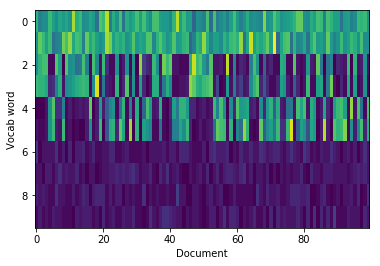

In [12]:
fig, ax = plt.subplots()
ax.imshow(data.todense(), aspect='auto')
ax.set_ylabel("Vocab word")
ax.set_xlabel("Document")
None

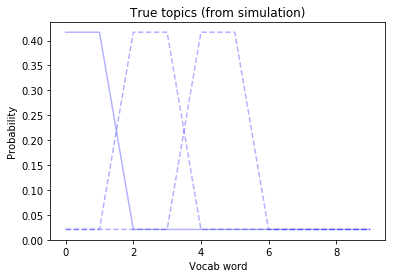

In [13]:
fig, ax = plt.subplots()
for i in range(len(sim.nodes)):
    linestyle = '-' if i == 0 else '--'
    ax.plot(sim.topics_by_index[i,:], color='b', linestyle=linestyle, alpha=0.3)
ax.set_title("True topics (from simulation)")
ax.set_xlabel("Vocab word")
ax.set_ylabel("Probability")
ax.set_ylim(0, None)
None

In [14]:
paths = list(explore_branching_factors([sim.num_leaves]))

In [15]:
model = SimpleHierarchicalTopicModel(
    branching_factors = [sim.num_leaves],
    stopping_condition = StoppingCondition(min_rel_increase = 1e-5, delay_epochs = 5, max_epochs = 200),
    batch_size = None,
    vocab = vocab,
    save_params_history = True,
    #paths = [(i,) for i in range(sim.num_leaves)],
    prior_params_DL = 0.01,
    prior_params_DD = 1,
    prior_params_DV = 0.1,
    #update_order = ["D", "L", "DD", "DL", "DV", ],
    stats_saver = StatsSaver("latest_stats.txt", stats = ["epoch_index", "ELBO", "var_params_DV"]),
    initializer = KMeansInitializer(data = data, paths = paths, low = 0.01, high = 1.99),
    #initializer = UniformInitializer(low = 0.01, high = 1.99),
    #initializer = CustomInitializer(sim, topics_noise = 0.1),  # <-- "cheating" based on simulation
)

In [16]:
lda_mode = all(len(x) == 1 for x in model.nodes)
print("LDA mode: {}".format(lda_mode))

LDA mode: False


In [17]:
model.fit(data)
top_words = model.get_top_words_by_node(num_words = 10)
model.print_top_words_by_node(num_words = 10);

 74%|███████▍  | 149/200 [00:08<00:02, 17.91it/s, Status=computing statistics]

Top words by node:
()  : w0, w1, w3, w2, w5, w4, w8, w6, w7, w9
(0,): w5, w4, w1, w0, w7, w6, w9, w8, w3, w2
(1,): w2, w1, w3, w0, w6, w7, w9, w8, w4, w5


In [18]:
topic_vectors = model.get_expected_topic_vectors()

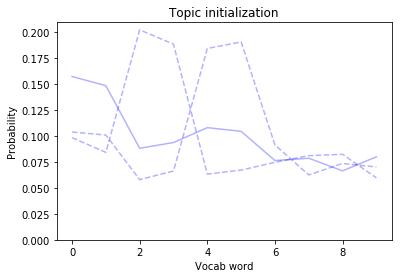

In [19]:
fig, ax = plt.subplots()
for i in range(len(model.nodes)):
    linestyle = '-' if i == 0 and not lda_mode else '--'
    current_params = model.stats_by_epoch[0]["var_params_DV"][i,:]
    current_topic = mean_dirichlet(current_params)
    ax.plot(current_topic, color='b', linestyle=linestyle, alpha=0.3)
ax.set_title("Topic initialization")
ax.set_xlabel("Vocab word")
ax.set_ylabel("Probability")
ax.set_ylim(0, None)
None

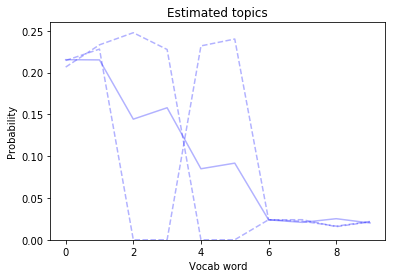

In [20]:
fig, ax = plt.subplots()
for i in range(len(model.nodes)):
    linestyle = '-' if i == 0 and not lda_mode else '--'
    ax.plot(topic_vectors[i,:], color='b', linestyle=linestyle, alpha=0.3)
ax.set_title("Estimated topics")
ax.set_xlabel("Vocab word")
ax.set_ylabel("Probability")
ax.set_ylim(0, None)
None

In [21]:
def leaves_to_hierarchy(topics_by_leaf):
    num_leaves = topics_by_leaf.shape[0]
    vocab_size = topics_by_leaf.shape[1]
    root = topics_by_leaf[0, :].copy()
    for i in range(1, num_leaves):
        root = np.minimum(root, topics_by_leaf[i, :])

    new_topics_by_leaf = topics_by_leaf.copy()
    for i in range(num_leaves):
        new_topics_by_leaf[i, :] -= root

    # Last step: normalize all vectors
    root /= np.sum(root)
    new_topics_by_leaf /= np.sum(new_topics_by_leaf, axis=-1, keepdims=True)

    return np.concatenate([root[np.newaxis, :], new_topics_by_leaf], axis=0)

In [22]:
if lda_mode:
    topic_vectors_new = leaves_to_hierarchy(topic_vectors)

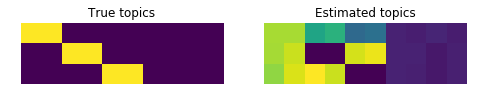

In [23]:
ax_shape = np.array([1,3]) if lda_mode else np.array([1,2])
fig, ax = plt.subplots(*ax_shape, figsize=4*ax_shape[::-1])
ax[0].imshow(sim.topics_by_index);
ax[0].set_title("True topics");
ax[0].axis('off');
ax[1].imshow(topic_vectors);
ax[1].set_title("Estimated topics");
ax[1].axis('off');
if lda_mode:
    ax[2].imshow(topic_vectors_new);
    ax[2].set_title("Estimated topics,\npost-processed");
    ax[2].axis('off');

In [24]:
if lda_mode:
    fig, ax = plt.subplots()
    for i in range(topic_vectors_new.shape[0]):
        linestyle = '-' if i == 0 else '--'
        ax.plot(topic_vectors_new[i,:], color='b', linestyle=linestyle, alpha=0.3)
    ax.set_title("Estimated topics, post-processed")
    ax.set_xlabel("Vocab word")
    ax.set_ylabel("Probability")
    ax.set_ylim(0, None)

Max ELBO: -19137.40


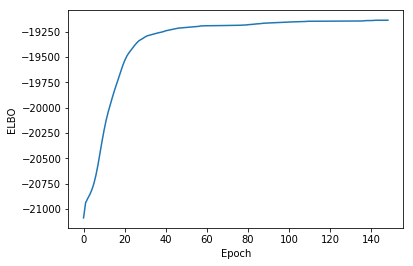

In [25]:
fig, ax = plt.subplots()
ax.plot(model.get_stats_by_epoch("epoch_index"), model.get_stats_by_epoch("ELBO"))
ax.set_xlabel("Epoch")
ax.set_ylabel("ELBO")
print("Max ELBO: {:.2f}".format(np.max(model.get_stats_by_epoch("ELBO", include_init=False))))
None

In [26]:
elbo_history = model.get_stats_by_epoch("ELBO", include_init = False)
diffs = elbo_history[1:] - elbo_history[:-1]
decrease_indices = (diffs < 0).nonzero()[0]
if decrease_indices.size > 0:
    print("Found decreasing ELBO at {}".format(decrease_indices))
else:
    print("ELBO never decreased")

ELBO never decreased


In [27]:
var_params = dict()
for name in model.update_order:
    var_params[name] = model.get_stats_by_epoch("var_params_" + name)
epoch_indices = model.get_stats_by_epoch("epoch_index")

In [28]:
for name in model.update_order:
    print("{:2}: {}".format(name, var_params[name].shape))

L : (150, 10000, 2)
D : (150, 10000, 2)
DL: (150, 100, 2)
DD: (150, 100, 2)
DV: (150, 3, 10)


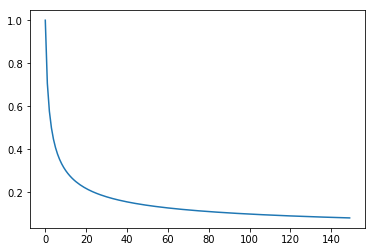

In [29]:
plt.plot(model.get_stats_by_epoch("step_size"));

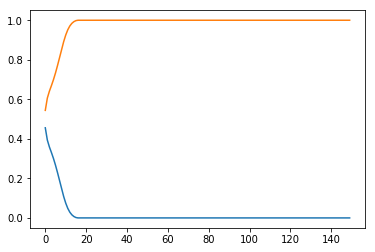

In [30]:
plt.plot(mean_dirichlet(var_params["DL"][:, 0, :]));

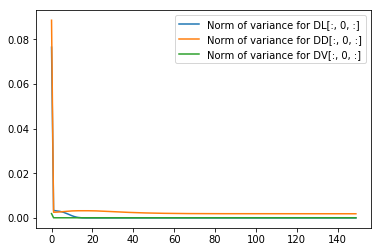

In [31]:
fig, ax = plt.subplots()
for name in ["DL", "DD", "DV"]:
    ax.plot(norm_variance_dirichlet(var_params[name][:, 0, :]),
        label = "Norm of variance for {}[:, 0, :]".format(name))
ax.legend(loc='best')
None

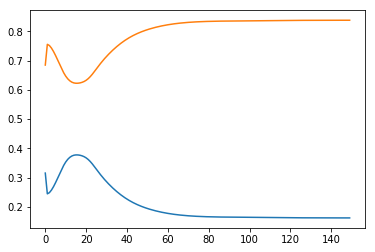

In [32]:
plt.plot(mean_dirichlet(var_params["DD"][:, 0, :]));

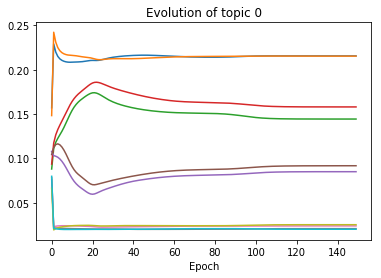

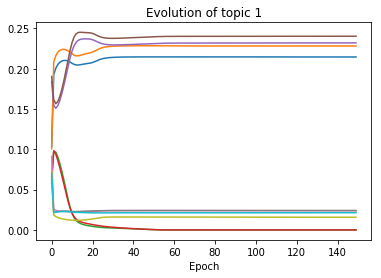

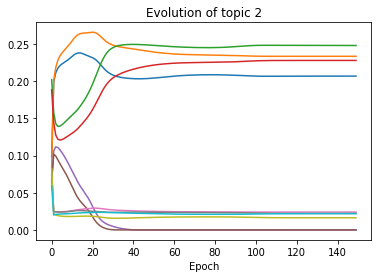

In [33]:
for i in range(len(model.nodes)):
    fig, ax = plt.subplots()
    ax.plot(mean_dirichlet(var_params["DV"][:, i, :]))
    ax.set_title("Evolution of topic {}".format(i))
    ax.set_xlabel("Epoch")
None

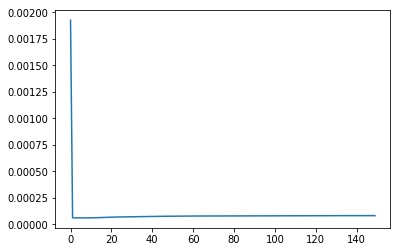

In [34]:
zzz = norm_variance_dirichlet(var_params["DV"][:, 0, :])
plt.plot(zzz);

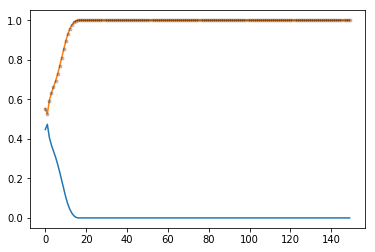

In [35]:
plt.plot(var_params["L"][:, 0, :]);
plt.plot(mean_discrete(var_params["L"][:, 0, :]), 'k.', alpha=0.2);

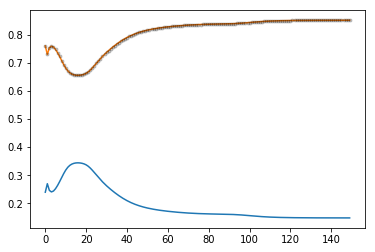

In [36]:
plt.plot(var_params["D"][:, 0, :]);
plt.plot(mean_discrete(var_params["D"][:, 0, :]), 'k.', alpha=0.2);

In [37]:
# Compare topic vectors to mean_dirichlet of most recent DV params (values should match)
zzz = mean_dirichlet(model.get_stats_by_epoch("var_params_DV")[-1, :, :])
np.linalg.norm(topic_vectors - zzz)

0.0

In [38]:
from scipy.stats import beta

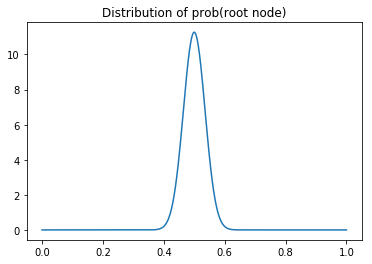

In [39]:
fig, ax = plt.subplots()
xx = np.linspace(0,1,1000)
yy = beta.pdf(xx, a=sim.alpha_depths[1], b=sim.alpha_depths[0])
ax.plot(xx, yy)
ax.set_title("Distribution of prob(root node)");

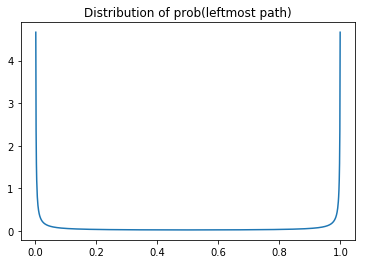

In [40]:
fig, ax = plt.subplots()
xx = np.linspace(0,1,1000)
yy = beta.pdf(xx, a=sim.alpha_leaves[1], b=sim.alpha_leaves[0])
ax.plot(xx, yy)
ax.set_title("Distribution of prob(leftmost path)");

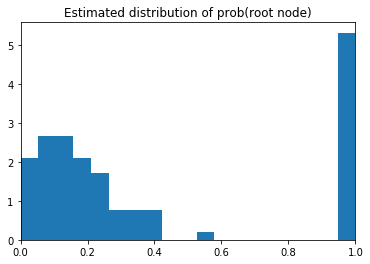

In [41]:
fig, ax = plt.subplots()
ax.hist(mean_dirichlet(model.var_params_DD)[:, 0], normed=True, bins=np.linspace(0,1,20));
ax.set_xlim(0, 1);
ax.set_title("Estimated distribution of prob(root node)");

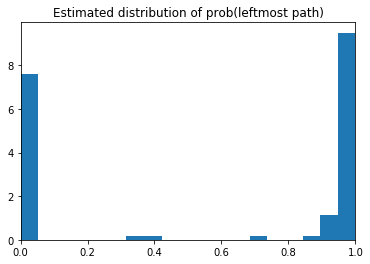

In [42]:
fig, ax = plt.subplots()
ax.hist(mean_dirichlet(model.var_params_DL)[:, 0], normed=True, bins=np.linspace(0,1,20));
ax.set_xlim(0, 1);
ax.set_title("Estimated distribution of prob(leftmost path)");